<a href="https://colab.research.google.com/github/tanabarr/ai-science-training-series/blob/main/Copy_of_02_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Data with Machine Learning
Another common task in data analysis is clustering data into groups using automated algorithms. There are machine learning algorithms to iteratively collects points together and form clusters. These are generally classified as _unsupervised_ learning because there is no direct input (data or otherwise) from the user required.
this
To demonstrate, we will go through an example here. The point is to show how algorithms can learn features about data that we care about.

The [Scikit Learn](https://scikit-learn.org/stable/user_guide.html) is a toolkit we can use to quickly generate a few clusters of data in two dimensions and we demonstrate how to do that here:

(400, 2) (400,) (4, 2)


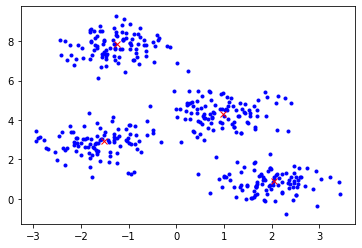

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import IPython.display as ipydis

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets import make_blobs

npoints = 400
N = 4
x, cluster_labels, cluster_centers = make_blobs(n_samples=npoints, centers=N,
                       cluster_std=0.60, random_state=0,
                       return_centers=True)
print(x.shape,cluster_labels.shape,cluster_centers.shape)
plt.plot(x[:, 0], x[:, 1],'b.')
plt.plot(cluster_centers[:,0],cluster_centers[:,1],'rx')

Here `x` is an array of the data points, `cluster_labels` is an array which labels to which group each point belongs (0-3), `cluster_centers` is a list of the 4 cluster center points.


# K-means

_K-means_ is a straightforward method to understand that follows these steps:
1. Given a set of points $x$, randomly select $N$ center points, or centroids, $c$.
2. Calculate the distance of each point to each centroid.
3. Assign points the label $0$ to $(N-1)$ based on to which centroid they are closest.
4. Calculate new centroids based on the center of mass of each cluster of points.
5. Repeat Steps 2-4 until one of these occurs:
   - centroids no longer shift more than some defined distance, $\delta$
   - no points change their label
   - some predefined iteration max, $N_{iter}$, is reached


In [ ]:
def initialize_centroids(x,N):
   x_indices = np.random.choice(np.arange(0,x.shape[0]),N)
   centroids = x[x_indices]
   return centroids

def get_new_centroids(x, labels, N):
    """returns the new centroids assigned from the points closest to them"""
    return np.array([x[labels==k].mean(axis=0) for k in range(N)])

In [ ]:
# distance is sqrt( (x - x')**2 + (y - y')**2 )
def assign_labels(x,c):
   # centroids are shape [N,2]
   # x are shape [npoints,2]
   # add middle index to centroids to properly broadcast in math operations
   c = c[:,np.newaxis,:] # [N,1,2]
   
   # calculate (x - x')**2 and (y - y')**2
   # x is shape [npoints,2], c is [N,1,2] results in an array of shape: [N,npoints,2]
   dist2 = (x - c)**2
   
   # calculate (x - x')**2 + (y - y')**2
   dist2 = dist2.sum(axis=2) # [N,npoints]
   
   # out of the N distances, return the index (0-(N-1)) of the one that is the minimum.
   label = np.argmin(dist2,axis=0) # [npoints]

   return label

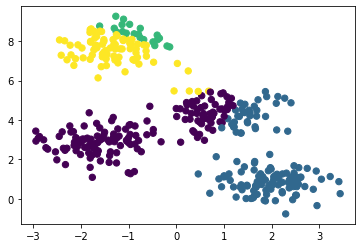

In [ ]:
c = initialize_centroids(x,N)
l = assign_labels(x,c)
plt.scatter(x[:, 0], x[:, 1], c=l, s=40, cmap='viridis')

Init 1/10 with method k-means++
Inertia for init 1/10: 434.3980751354604
Init 2/10 with method k-means++
Inertia for init 2/10: 550.6651364997224
Init 3/10 with method k-means++
Inertia for init 3/10: 502.704492677715
Init 4/10 with method k-means++
Inertia for init 4/10: 347.0628031336445
Init 5/10 with method k-means++
Inertia for init 5/10: 384.34147141248593
Init 6/10 with method k-means++
Inertia for init 6/10: 338.56036304340796
Init 7/10 with method k-means++
Inertia for init 7/10: 633.5912197074404
Init 8/10 with method k-means++
Inertia for init 8/10: 437.33073903336015
Init 9/10 with method k-means++
Inertia for init 9/10: 301.23368184531034
Init 10/10 with method k-means++
Inertia for init 10/10: 947.729810766343
Minibatch step 1/400: mean batch inertia: 1.1169835830163735
Minibatch step 2/400: mean batch inertia: 0.7283858739362978, ewa inertia: 0.7283858739362978
Minibatch step 3/400: mean batch inertia: 0.7227715779614726, ewa inertia: 0.7255857263179312
Minibatch step 4/

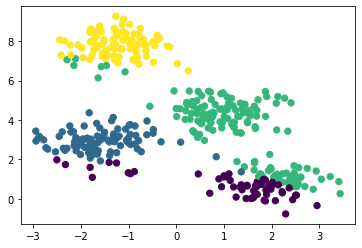

In [ ]:
delta = 0.01
batch_size = .25
loop_N = 0 #30
working_dset = pd.DataFrame(x)
step = 0

# initiate clusters by defining centroids
last_centroids = initialize_centroids(x,N)
updated_labels = assign_labels(x,last_centroids)

# get new batch of samples to init last_labels
xs = working_dset.sample(frac = batch_size).to_numpy()
last_labels = assign_labels(xs,last_centroids)


def get_accuracy(in_labels):
   # we can use the "truth" labels, cluster_labels to see how well we are doing
   # accuracy: # of points correctly labeled / total number of points
   accuracy = np.sum((cluster_labels == in_labels).astype(int)) / cluster_labels.shape[0]
   print('accuracy: ',accuracy)

def update_labels(x,xs,in_labels,out_labels):
   print('update labels: in {}, out {}'.format(xs.shape, x.shape))
   i = 0
   x_list = x.tolist()
   in_labels_list = in_labels.tolist()
   new_labels = out_labels.tolist()   
      
   for p in xs:
      # Find the index of the item in the master population and update the same
      # index in the master label array with the new label value.
      index = x_list.index(p.tolist())
      old = new_labels[index] 
      new = in_labels_list[i]
      i += 1
      if old != new:
         print('index {} label {} -> {}'.format(index, old, new))
         new_labels[index] = new
   
   return np.asarray(new_labels)
      
for i in range(loop_N):
   # get new batch of samples for this iteration
   xs = working_dset.sample(frac = batch_size).to_numpy()
   
   #centroids = get_new_centroids(x,last_labels,N)
   centroids = get_new_centroids(xs,last_labels,N)
   labels = assign_labels(xs,centroids)
   
   #updated_labels = update_labels(x, xs, labels)
   #labels = assign_labels(xs,centroids)

   # test if centroids have stopped moving
   if np.all(np.abs(last_centroids - centroids) < delta):
      print('centroids unchanged as of step %d' % step)
      break
   elif np.all(labels == last_labels):
      print('point labels unchanged as of step %d' % step)
      break
   else:
      last_labels = labels
      last_centroids = centroids
      updated_labels = update_labels(x,xs,labels,updated_labels)

   print(get_accuracy(updated_labels))
   print('accuracy: truth centres: {}, actual: {}', cluster_centers, last_centroids)
   plt.scatter(x[:, 0], x[:, 1], c=updated_labels, s=40, cmap='viridis')
   plt.title('step %d' % step)
   plt.show()
   time.sleep(1)
   ipydis.clear_output(wait=True)


Init 1/10 with method k-means++
Inertia for init 1/10: 160.67074878950393
Init 2/10 with method k-means++
Inertia for init 2/10: 228.9035480993541
Init 3/10 with method k-means++
Inertia for init 3/10: 372.9932745407009
Init 4/10 with method k-means++
Inertia for init 4/10: 129.12510750800723
Init 5/10 with method k-means++
Inertia for init 5/10: 145.00845162072665
Init 6/10 with method k-means++
Inertia for init 6/10: 139.4012166083501
Init 7/10 with method k-means++
Inertia for init 7/10: 394.8395376058695
Init 8/10 with method k-means++
Inertia for init 8/10: 314.10582319330206
Init 9/10 with method k-means++
Inertia for init 9/10: 163.61880482839223
Init 10/10 with method k-means++
Inertia for init 10/10: 166.54373962094337
Minibatch step 1/800: mean batch inertia: 0.6029912050257437
Minibatch step 2/800: mean batch inertia: 0.7097784880190062, ewa inertia: 0.7097784880190062
Minibatch step 3/800: mean batch inertia: 0.8260732835357193, ewa inertia: 0.7387796839084608
Minibatch ste

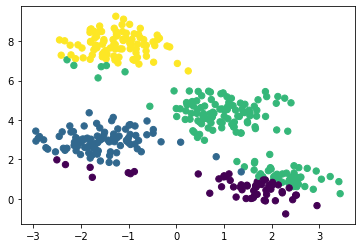

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import IPython.display as ipydis

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets import make_blobs

npoints = 400
N = 4

x, cluster_labels, cluster_centers = make_blobs(n_samples=npoints, centers=N,
                       cluster_std=0.60, random_state=0,
                       return_centers=True)


# Load data in X
batch_size_nr = 50 #45
#centers = [[1, 1], [-2, -1], [1, -2], [1, 9]]
#n_clusters = len(centers)
#X, labels_true = make_blobs(n_samples = 3000,
#							centers = centers,
#							cluster_std = 0.9)

# perform the mini batch K-means
mbk = MiniBatchKMeans(init ='k-means++', n_clusters = N,
					batch_size = batch_size_nr, n_init = 10,
					max_no_improvement = 30, verbose = 1)

mbk.fit(x)
mbk_means_cluster_centers = np.sort(mbk.cluster_centers_, axis = 0)
mbk_means_labels = pairwise_distances_argmin(x, mbk_means_cluster_centers)

# print the labels of each data
#print(mbk_means_labels)
plt.scatter(x[:, 0], x[:, 1], c=mbk_means_labels, s=40, cmap='viridis')

# Homework
Follow the example from the previous notebook [Linear Regression using SGD](./01_linear_regression_sgd.ipynb) and build a loop that properly finds the centers of these 4 clusters using k-means.

1